In [42]:
# Importing necessary libraries

# NumPy is used for numerical operations, such as array manipulations
import numpy as np

# Pandas is used for data manipulation and handling data in DataFrames (used to load and process data)
import pandas as pd

# os is a module to interact with the operating system, for file handling and path operations
import os

# TensorFlow is an open-source machine learning library for building and training models
import tensorflow as tf

# tqdm is a library to show progress bars, commonly used in loops
from tqdm import tqdm

# Keras functions for image preprocessing: ImageDataGenerator, load_img, and img_to_array
# ImageDataGenerator is used for real-time data augmentation during training
# load_img is used to load an image from disk
# img_to_array converts the image into a NumPy array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Keras Tokenizer for text processing, converting text into sequences of integers
from tensorflow.keras.preprocessing.text import Tokenizer

# pad_sequences is used to ensure that sequences (captions, etc.) are of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sequence is used to create a custom data generator for training batches
from tensorflow.keras.utils import Sequence

# to_categorical is used for one-hot encoding categorical labels (used for output layers)
from tensorflow.keras.utils import to_categorical

# Keras model-related imports to create and train models
from tensorflow.keras.models import Sequential, Model 


# Keras layers for building different parts of the neural network, like convolutions, dense layers, and activation functions
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer

# Additional layers for embedding, LSTM (for sequence modeling), and layer combinations
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

# Pre-trained models (VGG16, ResNet50, DenseNet201) from Keras applications to use as feature extractors
from tensorflow.keras.applications import DenseNet201, EfficientNetB0

# Adam optimizer for training models, widely used for its adaptive learning rate
from tensorflow.keras.optimizers import Adam

# Callbacks to monitor training, such as saving the best model, early stopping, and reducing learning rate on plateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warnings module to filter out unwanted warnings during execution
import warnings

# Matplotlib for creating visualizations (e.g., loss curves, model performance)
import matplotlib.pyplot as plt

# Seaborn for statistical data visualization, often used to create better-looking plots
import seaborn as sns

# textwrap for wrapping long text into shorter lines, useful for displaying captions or summaries
from textwrap import wrap

# Configuring the plotting style and font sizes for better readability of graphs

plt.rcParams['font.size'] = 12  # Set the font size for matplotlib plots
sns.set_style("dark")  # Set a dark style for seaborn plots
warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output

In [43]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [44]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

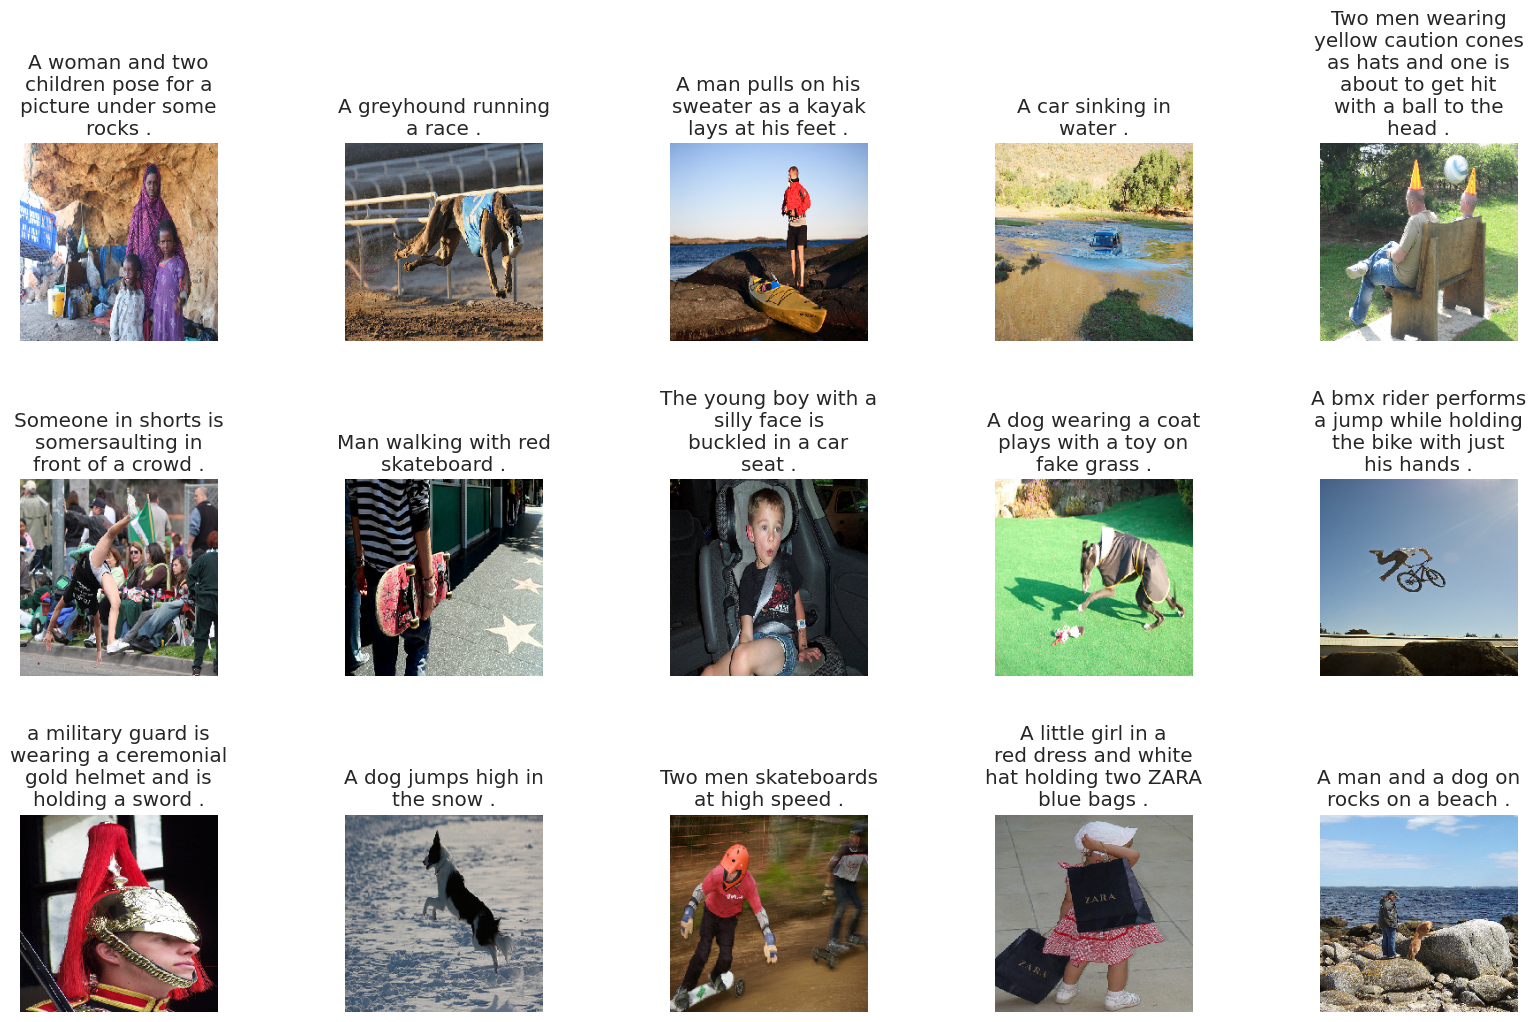

In [4]:
display_images(data.sample(15))

In [45]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [46]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [48]:
# Import the DenseNet201 model from Keras applications
model = DenseNet201()  # Initialize the DenseNet201 model with default weights (typically ImageNet)

# Create a new model that takes the input of DenseNet201 and outputs the second-to-last layer's output
# This is done to extract image features instead of class predictions
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Set the image size to 224x224 (this size is typically required for DenseNet201 input)
img_size = 224  

# Initialize an empty dictionary to store the extracted features for each image
features = {}

# Loop through each unique image name in the 'data' DataFrame
for image in tqdm(data['image'].unique().tolist()):  
    # Load the image from the specified path and resize it to the required size (224x224)
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))  
    
    # Convert the image into a NumPy array (from PIL image to array)
    img = img_to_array(img)  
    
    # Normalize pixel values to the range [0, 1] (originally, pixel values are in the range [0, 255])
    img = img / 255.  
    
    # Add an additional dimension to the image to make it compatible with the model's expected input shape
    # The model expects input in the form (batch_size, height, width, channels), so we add an extra batch dimension
    img = np.expand_dims(img, axis=0)  
    
    # Use the feature extraction model to generate a feature vector for the image
    # The verbose=0 parameter ensures that no progress information is printed
    feature = fe.predict(img, verbose=0)  
    
    # Store the feature vector in the 'features' dictionary, using the image name as the key
    features[image] = feature  

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [11:23<00:00, 11.84it/s]


In [49]:
features[image][0].shape

(1920,)

In [50]:
image

'997722733_0cb5439472.jpg'

In [51]:
len(features)

8091

In [52]:
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CustomDataGenerator(Sequence):
    """
    Custom Data Generator to yield batches of image features and corresponding caption sequences.
    
    Attributes:
    -----------
    df : DataFrame
        DataFrame containing image identifiers and their corresponding captions.
    X_col : str
        Name of the column in the DataFrame that contains image identifiers.
    y_col : str
        Name of the column in the DataFrame that contains captions.
    batch_size : int
        Number of samples per batch.
    directory : str
        Directory where the images are stored.
    tokenizer : Tokenizer
        Tokenizer object used to convert text into sequences of integers.
    vocab_size : int
        Size of the vocabulary for the output categorical sequences.
    max_length : int
        Maximum length for the input sequences (captions) to be padded.
    features : dict
        Dictionary containing image features extracted from a pre-trained model.
    shuffle : bool, optional
        Whether to shuffle the data at the end of each epoch (default is True).
    n : int
        Total number of samples in the DataFrame.
    """
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        """Initializes the generator with the given parameters."""
        self.df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original one
        self.X_col = X_col  # Column name for image identifiers
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Directory where images are stored
        self.batch_size = batch_size  # Number of samples in each batch
        self.tokenizer = tokenizer  # Tokenizer to convert text to sequences
        self.vocab_size = vocab_size  # Size of the vocabulary for the captions
        self.max_length = max_length  # Maximum length of input sequences for padding
        self.features = features  # Pre-extracted features of the images
        self.shuffle = shuffle  # Whether to shuffle the data at the end of each epoch
        self.n = len(self.df)  # Total number of samples
    
    def on_epoch_end(self):
        """Shuffles the DataFrame at the end of each epoch if shuffle is True."""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
    
    def __len__(self):
        """Returns the number of batches per epoch."""
        return self.n // self.batch_size  # Floor division to get the number of complete batches
    
    def __getitem__(self, index):
        """Generates one batch of data."""
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]  # Get batch samples
        X1, X2, y = self.__get_data(batch)  # Get data for the batch
        return (X1, X2), y  # Return inputs and output as a tuple
    
    def __get_data(self, batch):
        """Generates data for a given batch of samples."""
        X1, X2, y = list(), list(), list()  # Initialize empty lists to store features, input sequences, and outputs
        
        images = batch[self.X_col].tolist()  # Get list of image identifiers in the batch
        
        for image in images:
            feature = self.features[image][0]  # Extract pre-computed image feature from the features dictionary
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()  # Get captions for the image
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]  # Convert caption to sequence of integers
                
                for i in range(1, len(seq)):
                    # Split the caption into input and output sequences
                    in_seq, out_seq = seq[:i], seq[i]  # Input sequence and the next word as the output
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]  # Pad input sequence to max_length
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]  # Convert output to one-hot encoding
                    
                    X1.append(feature)  # Append image feature as input
                    X2.append(in_seq)  # Append the input sequence
                    y.append(out_seq)  # Append the output (next word in sequence)
        
        # Convert lists to NumPy arrays for better performance
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y  # Return image features, input sequences, and output sequences

change

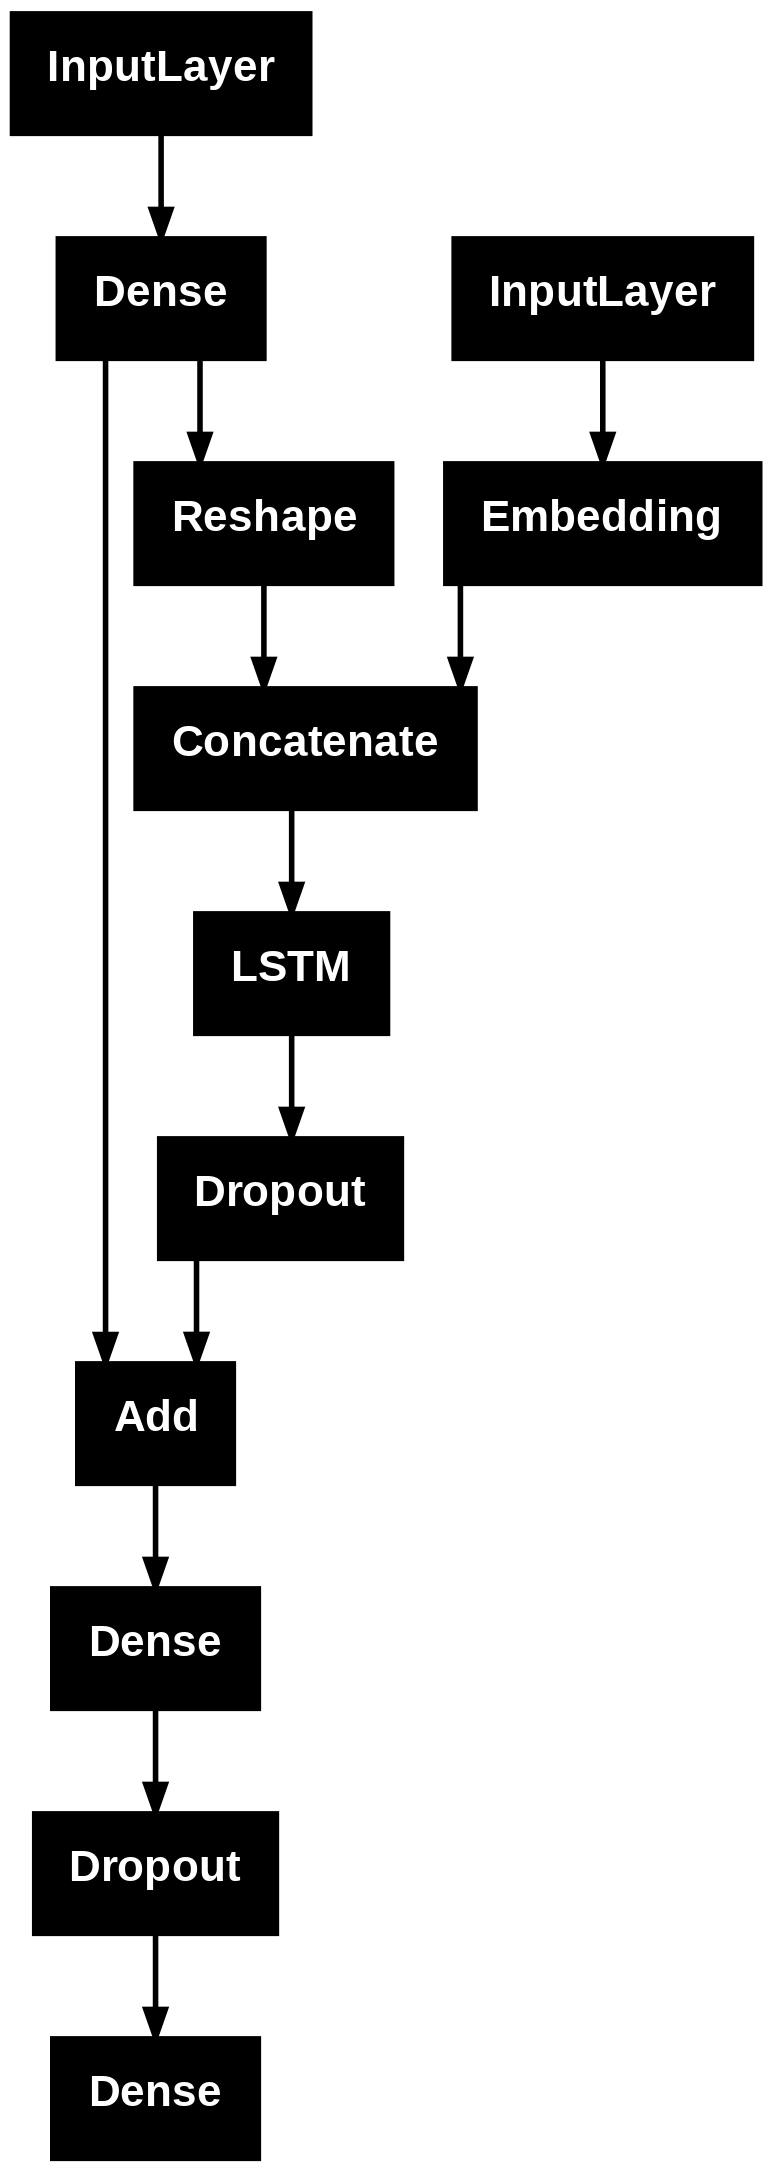

In [53]:
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, LSTM, Dropout, add, concatenate
from tensorflow.keras.models import Model

# Define two input layers
input1 = Input(shape=(1920,))  # Input for image features
input2 = Input(shape=(max_length,))  # Input for the caption sequence

# Image feature processing
img_features = Dense(256, activation='relu')(input1)  # Fully connected layer to reduce dimensionality
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)  # Reshape to (1, 256) to concatenate with LSTM output

# Caption (text) processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)  # Embedding layer for input captions
merged = concatenate([img_features_reshaped, sentence_features], axis=1)  # Concatenate image features with caption sequence
sentence_features = LSTM(256)(merged)  # LSTM processes the combined features

# Combine LSTM output with image features
x = Dropout(0.5)(sentence_features)  # Dropout to prevent overfitting
x = add([x, img_features])  # Skip connection to add image features to LSTM output
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(vocab_size, activation='softmax')(x)  # Output layer with softmax activation to predict the next word

# Create and compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)  # Define the model with two inputs and one output
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')  # Compile the model with categorical crossentropy loss


from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [54]:
caption_model.summary()# Create a training data generator
train_generator = CustomDataGenerator(
    df=train,  # DataFrame containing training data
    X_col='image',  # Column name with image identifiers
    y_col='caption',  # Column name with captions
    batch_size=64,  # Number of samples per batch
    directory=image_path,  # Path to the directory containing images
    tokenizer=tokenizer,  # Tokenizer to convert captions to sequences
    vocab_size=vocab_size,  # Total vocabulary size for one-hot encoding
    max_length=max_length,  # Maximum length for input sequences
    features=features  # Pre-computed image features
)

# Create a validation data generator
validation_generator = CustomDataGenerator(
    df=test,  # DataFrame containing validation data
    X_col='image',  # Column name with image identifiers
    y_col='caption',  # Column name with captions
    batch_size=64,  # Number of samples per batch
    directory=image_path,  # Path to the directory containing images
    tokenizer=tokenizer,  # Tokenizer to convert captions to sequences
    vocab_size=vocab_size,  # Total vocabulary size for one-hot encoding
    max_length=max_length,  # Maximum length for input sequences
    features=features  # Pre-computed image features
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        491,776 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 256)         │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 35, 256)        │              0 │ reshape_2[0][0],       │
│ (Concatenate)             │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback to save the model with the lowest validation loss
model_name = "model.keras"  # Change the file extension to '.keras'
checkpoint = ModelCheckpoint(
    model_name,  # Filepath where the model will be saved
    monitor="val_loss",  # Monitor the validation loss during training
    mode="min",  # Save the model when the validation loss is minimized
    save_best_only=True,  # Save only the model with the best validation loss
    verbose=1  # Print a message when the model is saved
)

# Callback to stop training early if the validation loss does not improve
earlystopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0,  # Minimum change in the monitored value to be considered an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print a message when early stopping is triggered
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Callback to reduce the learning rate if validation loss does not improve
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which the learning rate will be reduced
    verbose=1,  # Print a message when the learning rate is reduced
    factor=0.2,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    min_lr=1e-8  # Lower bound on the learning rate to avoid reducing it too much
)

In [56]:
# Train the image captioning model
history = caption_model.fit(
    train_generator,  # Training data generator
    epochs=50,  # Maximum number of epochs to train the model
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # List of callbacks to monitor and control training
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 5.7167
Epoch 1: val_loss improved from inf to 4.20020, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 296s 541ms/step - loss: 5.7155 - val_loss: 4.2002 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.2179
Epoch 2: val_loss improved from 4.20020 to 3.90030, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 4.2178 - val_loss: 3.9003 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 3.9250
Epoch 3: val_loss improved from 3.90030 to 3.77245, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 3.9250 - val_loss: 3.7724 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.7572
Epoch 4: val_loss improved from 3.77245 to 3.69679, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - loss: 3.7572 - val_loss: 3.6968 - learning_rate: 0.0010

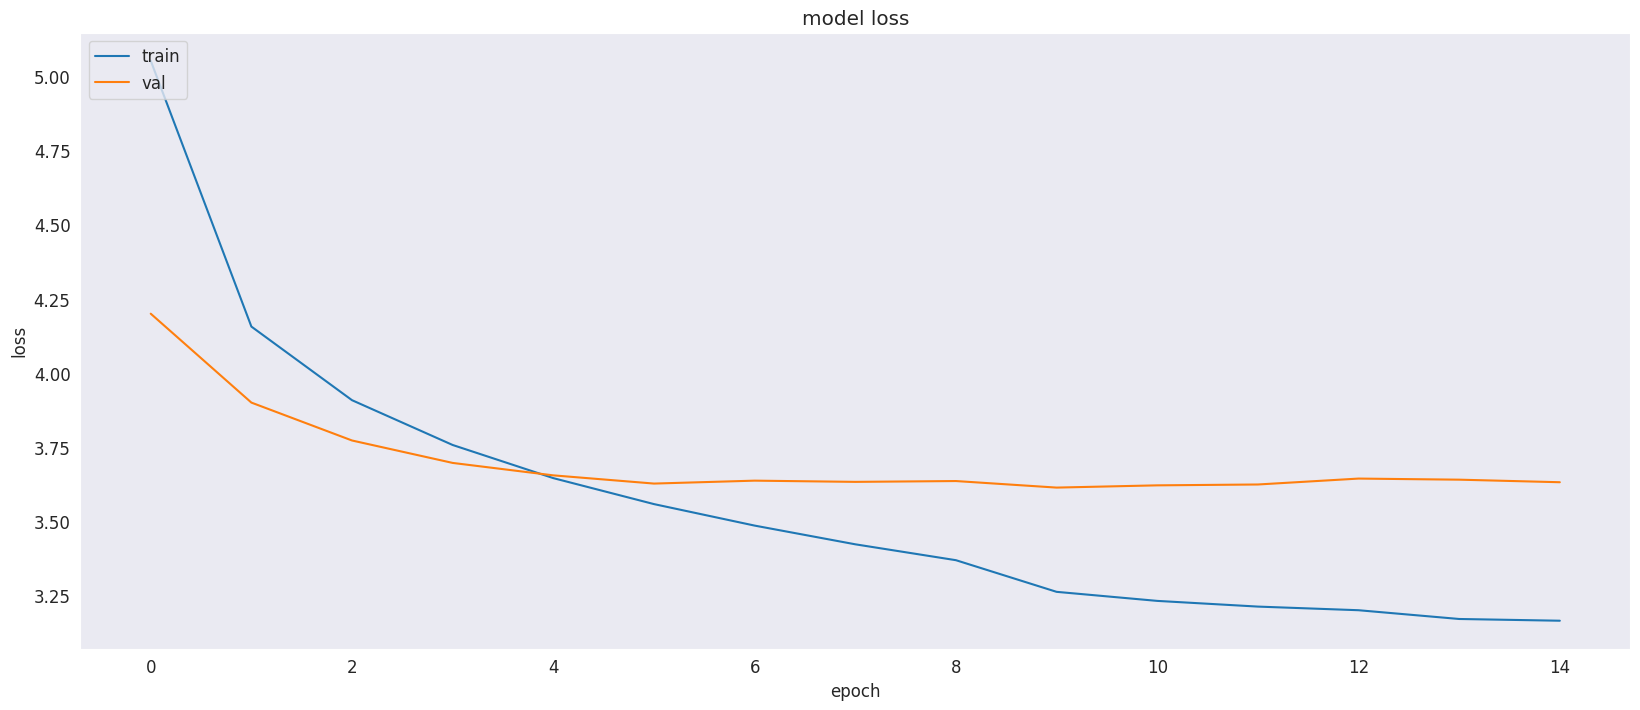

In [57]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
def idx_to_word(integer, tokenizer):
    """
    Converts an integer (word index) back to its corresponding word 
    using the tokenizer's word index.

    Parameters:
    -----------
    integer : int
        The index of the word to be converted.
    tokenizer : Tokenizer
        The tokenizer that contains the mapping of words to indices.

    Returns:
    --------
    str or None
        The word corresponding to the given index, or None if the index is not found.
    """
    for word, index in tokenizer.word_index.items():  # Loop through all word-index pairs in the tokenizer
        if index == integer:  # If the index matches the given integer
            return word  # Return the corresponding word
    return None  # If no match is found, return None

In [59]:
def predict_caption(model, image, tokenizer, max_length, features):
    """
    Generates a caption for a given image using the trained captioning model.
    
    Parameters:
    -----------
    model : keras.Model
        The trained image captioning model.
    image : str
        The identifier or key for the image in the features dictionary.
    tokenizer : Tokenizer
        The tokenizer object used to convert text into sequences of integers.
    max_length : int
        The maximum allowed length for the caption.
    features : dict
        A dictionary containing pre-extracted image features for all images.
    
    Returns:
    --------
    str
        The generated caption for the image.
    """
    
    feature = features[image]  # Extract the feature for the given image
    in_text = "startseq"  # Start the caption generation with the starting token
    
    for i in range(max_length):  # Limit the length of the caption to max_length
        # Convert the input text so far into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]  
        # Pad the sequence to ensure it has the required max_length
        sequence = pad_sequences([sequence], max_length)  
        
        # Predict the next word's index using the image feature and input sequence
        y_pred = model.predict([feature, sequence], verbose=0)  # Model predicts probabilities for each word in the vocabulary
        y_pred = np.argmax(y_pred)  # Choose the word with the highest probability
        
        word = idx_to_word(y_pred, tokenizer)  # Convert the predicted index back to a word
        
        if word is None:  # If no matching word is found, stop generation
            break
            
        in_text += " " + word  # Add the predicted word to the caption
        
        if word == 'endseq':  # If the 'endseq' token is predicted, end the generation
            break
            
    return in_text  # Return the full caption as a string

In [60]:
samples = test.sample(20)
samples.reset_index(drop=True,inplace=True)

In [61]:
samples

image  \
0   3702038926_966fdaa311.jpg   
1    533713001_2d36e93509.jpg   
2   3733074526_82aa8d5f8d.jpg   
3   3712923460_1b20ebb131.jpg   
4   3724581378_41049da264.jpg   
5    783353797_fdf91bdf4c.jpg   
6    697490420_67d8d2a859.jpg   
7    485054073_fef8b80b4b.jpg   
8    774009278_8e75b7d498.jpg   
9    480607352_65614ab348.jpg   
10   407569668_19b3f8eaf6.jpg   
11   396360611_941e5849a3.jpg   
12  3696698390_989f1488e7.jpg   
13  3718076407_0b4588d7bc.jpg   
14   380515798_c2abbf46b0.jpg   
15   990890291_afc72be141.jpg   
16   444872454_9f51e07f88.jpg   
17   827941668_2e4ac6cb39.jpg   
18   397815951_3b02090324.jpg   
19   421316045_ae7a1eb4bc.jpg   

                                              caption  
0   startseq the girl runs in the grass while othe...  
1   startseq group of people sit on an outdoor pat...  
2   startseq girl in costume participates in parad...  
3   startseq group of people wearing army clothes ...  
4                  startseq surfer riding wave endseq  
5   startseq the words look right with an arrow pa...  
6     startseq man prepares to take kayak ride endseq  
7   startseq the dog is trying to catch frisbee en...  
8   startseq white dog jumping in green grass by b...  
9   startseq man wearing colorful and striped swea...  
10  startseq three people are sitting at counter u...  
11  startseq person is standing on jagged rocks ab...  
12  startseq cyclist in green shirt doing trick on...  
13  startseq brown and white dog retrieving white ...  
14  startseq crowd walks along sidewalk of farmers...  
15  startseq man on bicycle riding on only one whe...  
16  startseq several young women walk near blossom...  
17          startseq kid splashes in the ocean endseq  
18  startseq two dogs play with each other on wood...  
19  startseq two young boys playing on white sofa ...

In [63]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

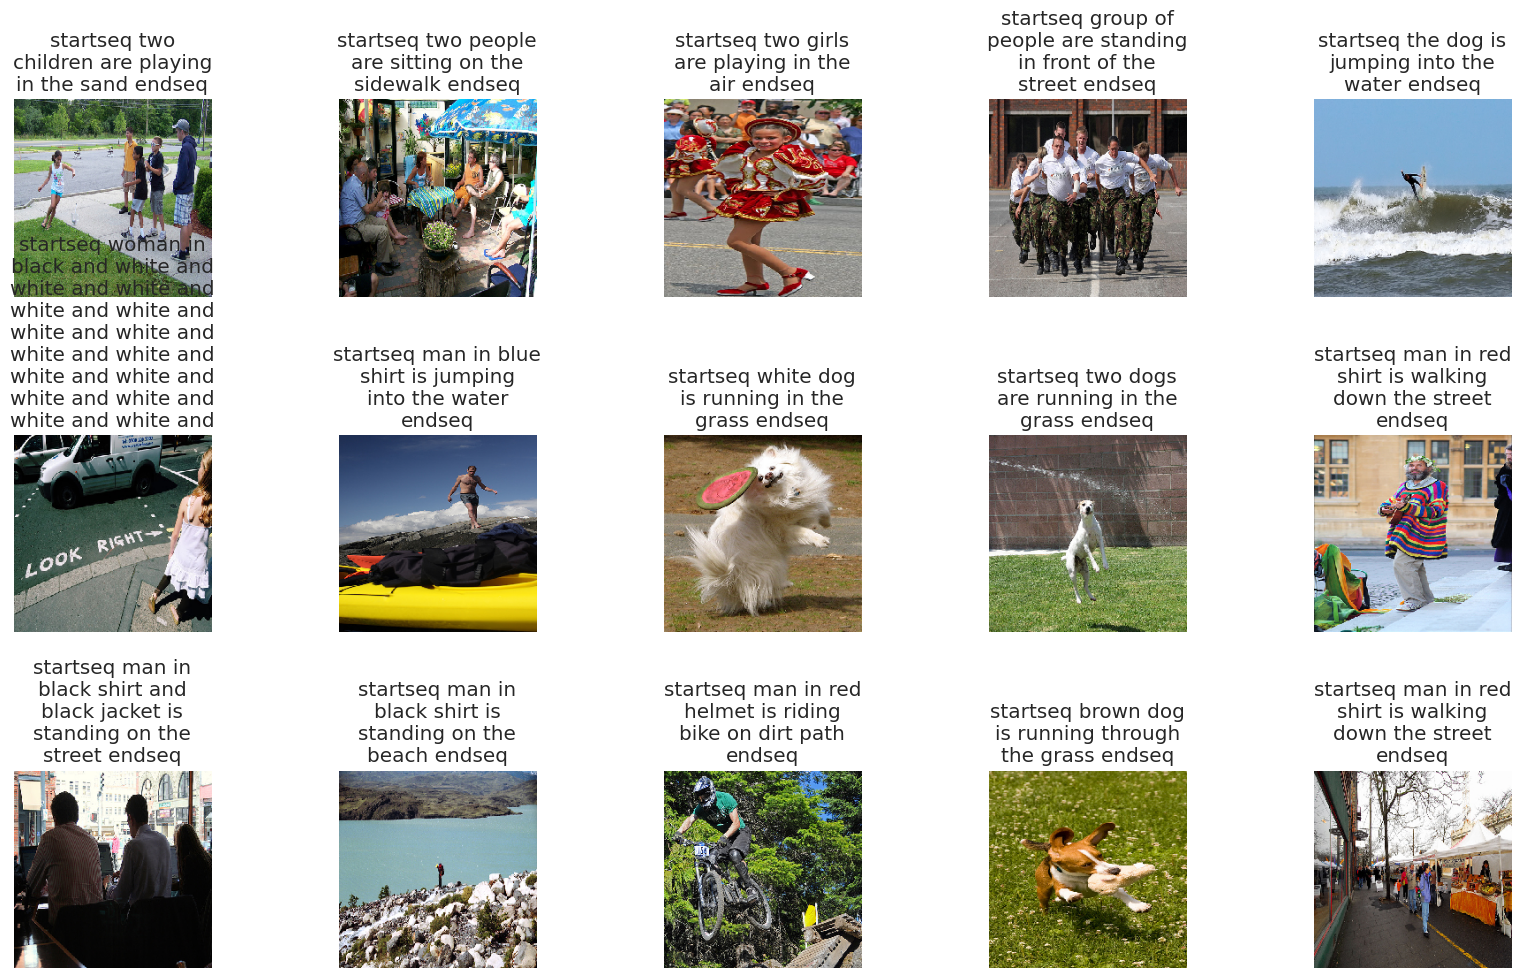

In [64]:
display_images(samples)

Record found: image                               397815951_3b02090324.jpg
caption    startseq black and white dog is playing with t...
Name: 18, dtype: object
Predicted Caption for 397815951_3b02090324.jpg: startseq black and white dog is playing with the ball endseq


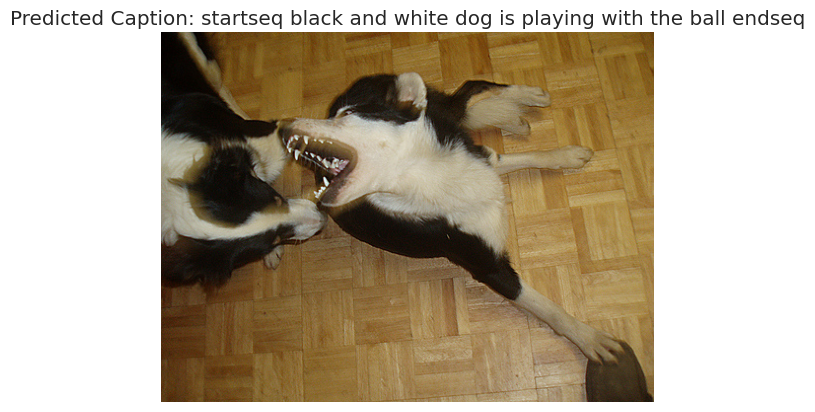

In [67]:
# Specify the image filename you want to test
image_name = "397815951_3b02090324.jpg"  # replace with your image name

# Check if the image exists in the DataFrame
matching_records = samples[samples['image'] == image_name]

if not matching_records.empty:
    # If a matching record exists, access it
    record = matching_records.iloc[0]
    print(f"Record found: {record}")
    
    # Load and preprocess the image
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0  # Normalize

    # Generate the caption using the caption model
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)

    # Print the predicted caption
    print(f"Predicted Caption for {image_name}: {caption}")

    # If you want to visualize the image:
    import matplotlib.pyplot as plt

    # Load and display the image
    img = load_img(os.path.join(image_path, record['image']))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Caption: {caption}")
    plt.show()

else:
    print(f"No matching record found for {image_name}")

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display image and caption
def display_image_and_caption(image_path, image_name, caption):
    # Load the image
    img = mpimg.imread(os.path.join(image_path, image_name))
    
    # Plot the image and display the caption
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.title(caption, fontsize=14)
    plt.show()

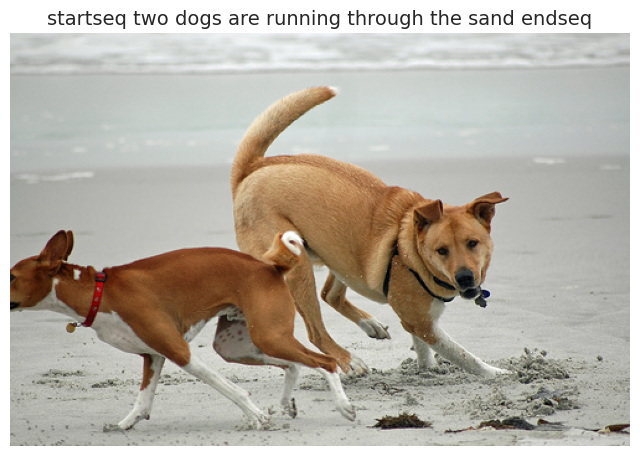

In [69]:
# Example usage
image_name = '1024138940_f1fefbdce1.jpg'  # Example image name
caption = predict_caption(caption_model, image_name, tokenizer, max_length, features)

# Display the image along with the generated caption
display_image_and_caption(image_path, image_name, caption)

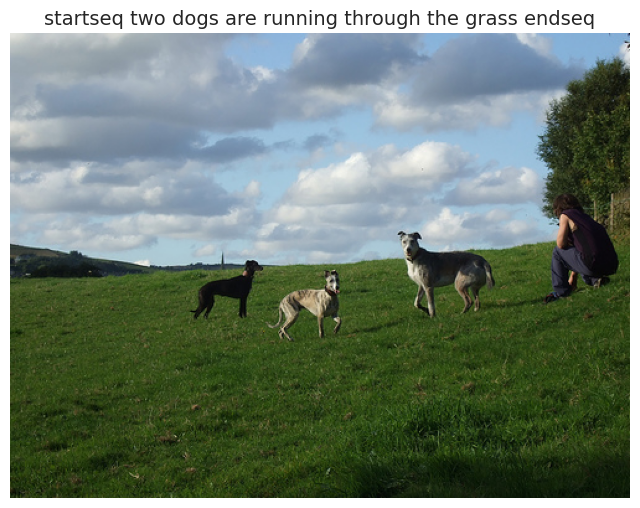

In [70]:
# Example usage
image_name = '1032122270_ea6f0beedb.jpg'  # Example image name
caption = predict_caption(caption_model, image_name, tokenizer, max_length, features)

# Display the image along with the generated caption
display_image_and_caption(image_path, image_name, caption)

In [71]:
caption_model.save("imageCaption.keras")

In [75]:
import pickle

with open('Imgfeatures.pkl', 'wb') as f:
    pickle.dump(features, f)
